In [1]:
import torch
import doubleauction

In [2]:
import torch.nn as nn

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, hidden3=64):
        super(Critic, self).__init__()
        self.bn1 = nn.BatchNorm1d(nb_states)
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.bn2 = nn.BatchNorm1d(hidden1+nb_actions)
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        
        self.bn3 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        
        self.bn4 = nn.BatchNorm1d(hidden3)
        self.fc4 = nn.Linear(hidden3, 1)

        self.relu = nn.ReLU()
    
    def forward(self, s, a):
        out = self.fc1(self.bn1(s))
        out = self.relu(out)

        out = self.fc2(self.bn2(torch.cat([out,a],1)))
        out = self.relu(out)
        
        out = self.fc3(self.bn3(out))
        out = self.relu(out)
        
        out = self.fc4(self.bn4(out))
        
        return out
    
    

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, init_w=3e-3):
        super(Actor, self).__init__()
        self.bn1 = nn.BatchNorm1d(nb_states)
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.bn2 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        self.bn3 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, nb_actions)
        
        self.relu = nn.ReLU()   
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        out = self.fc1(self.bn1(x))
        out = self.relu(out)
        
        out = self.fc2(self.bn2(out))
        out = self.relu(out)
        out = self.fc3(self.bn3(out))
#         out = self.softplus(out)
        
        return out
    
    

In [3]:
import torch.nn as nn

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, hidden3=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 1)

        self.relu = nn.ReLU()
    
    def forward(self, s, a):
        out = self.fc1(s)
        out = self.relu(out)

        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
    
        return out
    
    

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, init_w=3e-3):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        self.fc3 = nn.Linear(hidden2, nb_actions)
        
        self.relu = nn.ReLU()   
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
#         out = self.softplus(out)
        
        return out
    
    

In [4]:

import scipy.stats
import numpy as np
from doubleauction.agents import Buyer, Seller
import torch
        
class DDPGSeller(Seller):
    def __init__(self, agent_id: str,  reservation_price: float, *,
                    max_noise=50., anneal_steps=1e4, min_noise=5.,
                    batch_size = 64, mem_size=100000, lr=1e-2, width_actor=64, width_critic=64,
                    tau=1e-2, discount=0.98, wd = 1e-4):
        """
        A seller agent that extends the market agent
        :param agent_id: a unique id that differentiates this agent to other agents
        :param reservation_price: the reservation price, or minimum price that this agent is
        willing to sell
        """
        super().__init__(agent_id, reservation_price)
        self.max_noise = max_noise
        self.anneal_steps = anneal_steps
        self.min_noise = min_noise
        
        self.sigma = max_noise
        
        self.actor = Actor(5, 1, hidden1=width_actor, hidden2=width_actor)
        self.actor_target = Actor(5, 1, hidden1=width_actor, hidden2=width_actor)
        self.actor_optim  = torch.optim.Adam(self.actor.parameters(), lr=lr, weight_decay=wd)

        self.critic = Critic(5, 1, hidden1=width_critic, hidden2=width_critic)
        self.critic_target = Critic(5, 1, hidden1=width_critic, hidden2=width_critic)
        self.critic_optim  = torch.optim.Adam(self.critic.parameters(), lr=lr, weight_decay=wd)

        self.memory = SequentialMemory(limit=mem_size, window_length=1)
    
        self.tau = tau
        self.lr = lr
        self.width_actor = width_actor
        self.width_critic = width_critic

        self.mem_size = mem_size
        self.batch_size = batch_size
        
        self.discount = discount
        
        self.criterion = nn.MSELoss()
        
        self.eval = False
        
        self.game_count = 0
        
        self.new_game()
        

    
    def new_game(self):
        self.last_demand = 0
        self.game_first = True
        self.round_first = True
        self.last_successful = False
        
        self.state = None
        self.action = None
        
        self.new_round()
        
        if not self.eval:
            self.sigma = self.max_noise - self.game_count * (self.max_noise - self.min_noise) / self.anneal_steps
            self.sigma = max(self.min_noise, self.sigma)
            
        self.game_count += 1
        
    def new_round(self):
        self.round_first = True
        
        
    def decide(self, observations):
        
        ## update state
        self.state = np.array([self.last_demand, self.last_successful,
                               self.game_first, self.round_first,
                               self.reservation_price], dtype=np.float)
        s = torch.tensor(self.state).float().unsqueeze(0)

        with torch.no_grad():
            self.actor.eval()
            if self.eval:
                a = self.actor(s)
                a = a.item()
            else:
                
                n = np.random.normal(0, self.sigma)
                d = self.actor(s).item()
                a = d + n

#                 a = abs(a)
                print(d)
                
            self.actor.train()

        self.action = a
        
        self.last_demand = a
        self.game_first = False
        self.round_first = False

        return self.reservation_price + a
  

    def observe(self, reward, done):
        self.memory.append(self.state, self.action, reward, done)
        self.last_successful = (reward > 0)

        
    def learn(self):
        
        # perform grad descent    
        
        # Sample batch
        state_batch, action_batch, reward_batch, \
        next_state_batch, terminal_batch = self.memory.sample_and_split(self.batch_size)

        # Prepare for the target q batch
        with torch.no_grad():
            next_q_values = self.critic_target(
                torch.tensor(next_state_batch, dtype=torch.float),
                self.actor_target(torch.tensor(next_state_batch, dtype=torch.float)))

            target_q_batch = torch.tensor(reward_batch, dtype=torch.float) + \
                self.discount*torch.tensor(terminal_batch, dtype=torch.float)*next_q_values

        # Critic update
        self.critic.zero_grad()

        q_batch = self.critic(torch.tensor(state_batch, dtype=torch.float), 
                                torch.tensor(action_batch, dtype=torch.float))

        value_loss = self.criterion(q_batch, target_q_batch)
        value_loss.backward()
        self.critic_optim.step()

        # Actor update
        self.actor.zero_grad()

        policy_loss = -self.critic(
            torch.tensor(state_batch, dtype=torch.float),
            self.actor(torch.tensor(state_batch, dtype=torch.float)))

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)
        

# Create environment

In [5]:
import matplotlib.pyplot as plt

In [6]:
import doubleauction
from doubleauction.agents import RandomSeller, RandomBuyer
from doubleauction.environments import MarketEnvironment
from doubleauction.matchers import RandomMatcher
from doubleauction.util import SequentialMemory, hard_update, soft_update
from doubleauction.util import generate_seller_prices_paper, generate_buyer_prices_paper

In [7]:
records = {}
records['rewards'] = []
records['demands'] = []
records['prices'] = []

In [8]:
rewards = []
epochs = 500
warmup_epochs = 20
seller_agent = DDPGSeller('learner', 0, 
                          discount = 0.97, lr = 3e-4, max_noise=22., min_noise=1.5, anneal_steps=400,
                          wd = 3e-3, mem_size=500000, tau=5e-3)

In [9]:
mdict = torch.load('results/models2')
seller_agent.actor.load_state_dict(mdict['actor'])
seller_agent.actor_target.load_state_dict(mdict['actor'])

seller_agent.critic.load_state_dict(mdict['critic'])
seller_agent.critic_target.load_state_dict(mdict['critic_target'])

<All keys matched successfully>

In [10]:
%%time
for e in range(epochs):
    seller_agent.reservation_price = generate_seller_prices_paper(1)[0]
    
    sellers = []
    for ii, p in enumerate(generate_seller_prices_paper(19)):
        sellers.append(RandomSeller('s'+str(ii), p))
    sellers.append(seller_agent)

    buyers = []
    for ii, p in enumerate(generate_buyer_prices_paper(20)):
        buyers.append(RandomBuyer('b'+str(ii), p))

    agents = sellers + buyers
    
    seller_agent.new_game()
    
    setting = {
        'self_last_offer': False,
        'same_side_last_offers': False,
        'other_side_last_offers': False,
        'completed_deals': False,
        'current_time': False,
        'max_time': False,
        'n_sellers': False,
        'n_buyers': False
    }

    ROUNDS_PER_GAME = 10
    
    market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_steps=10,
                                   matcher=RandomMatcher(reward_on_reference=True), setting=setting)
    init_observation = market_env.reset()

    round_avg = 0.
    offer_avg = 0.
    time_avg = 0.
    
    records['demands'].append([])
    records['rewards'].append([])
    records['prices'].append(seller_agent.reservation_price)

    
    for n_round in range(ROUNDS_PER_GAME):
        
        init_observation = market_env.reset()
        observations = {k.agent_id:None for k in agents}
        done = {k.agent_id:False for k in agents}
        reward_hist = []
        rounds = 0
        terminate_round = False
        
        seller_agent.new_round()
        
        records['demands'][-1].append([])
        records['rewards'][-1].append([])
        
        offers_list = []
        
        while not terminate_round:
            offers = {}

            offers = {a.agent_id : a.decide(observations[a.agent_id]) for a in agents}

            observations, rewards, done, _ = market_env.step(offers)
            reward_hist.append(rewards)
            rounds += 1

            terminate_round = all(done.values()) or rounds >= 10 or done['learner']

            # create record of experience
            seller_agent.observe(rewards['learner'], terminate_round and n_round+1==ROUNDS_PER_GAME)
            
            offers_list.append(offers['learner'] - seller_agent.reservation_price)
            
            records['demands'][-1][-1].append(offers['learner'] - seller_agent.reservation_price)
            records['rewards'][-1][-1].append(rewards['learner'])
            
            round_avg += rewards['learner']

            time_avg += 1
    
        offer_avg += sum(offers_list) / len(offers_list)
#         time_vs_rewards.append(round_avg)
#         time_vs_demand.append(sum(offers_list) / len(offers_list))
        
        if e >= warmup_epochs:
            seller_agent.learn()
    
    print('Epoch: {}, Avg. earnings: {}, Avg. demand: {}, Avg. time: {}'.format(e, round_avg / 10., 
                                                                            offer_avg / 10.,
                                                                            time_avg / 10.))
    
    

82.591552734375
15.765169143676758
81.70726013183594
17.772789001464844
83.17229461669922
17.996082305908203
15.114241600036621
66.51066589355469
16.738283157348633
82.98388671875
16.856060028076172
15.070321083068848
82.95304870605469
19.088266372680664
82.888671875
18.80286979675293
63.068275451660156
15.202396392822266
81.90463256835938
18.491960525512695
15.129348754882812
82.24122619628906
15.43398380279541
82.6380615234375
15.505826950073242
82.19448852539062
15.507482528686523
56.41104507446289
16.181001663208008
Epoch: 0, Avg. earnings: 1.082396069175384, Avg. demand: 36.72723631110022, Avg. time: 2.9
93.11326599121094
17.4564266204834
86.10690307617188
18.058652877807617
93.08732604980469
19.914003372192383
93.25019836425781
19.89044189453125
17.08477020263672
93.7042236328125
17.500877380371094
94.423095703125
18.93868064880371
92.6790771484375
19.898406982421875
92.35739135742188
18.526994705200195
92.64033508300781
18.21477699279785
93.84669494628906
18.809045791625977
16.9

109.6343994140625
21.634021759033203
19.93929100036621
110.2421646118164
21.632707595825195
20.031034469604492
110.03799438476562
23.152851104736328
20.172069549560547
110.37225341796875
Epoch: 6, Avg. earnings: -5.843256671403135, Avg. demand: 56.15988547955858, Avg. time: 7.2
88.44422912597656
19.247926712036133
16.138254165649414
89.59249114990234
17.916345596313477
88.45670318603516
17.68122673034668
89.13676452636719
18.060205459594727
16.18906593322754
88.42478942871094
18.88730812072754
88.71400451660156
16.70514488220215
87.78437805175781
17.42101287841797
89.12281036376953
19.67238998413086
89.16325378417969
16.14691734313965
88.80836486816406
19.257387161254883
88.37706756591797
19.77689552307129
89.455322265625
16.262048721313477
89.28329467773438
19.69015121459961
66.12061309814453
16.344757080078125
88.44967651367188
18.177289962768555
88.90402221679688
16.287700653076172
88.73377990722656
18.8359317779541
16.307315826416016
16.157751083374023
89.82740783691406
18.83092117

17.03227424621582
84.19380950927734
19.178438186645508
62.8709602355957
15.701315879821777
15.469199180603027
83.21321105957031
22.151451110839844
15.321009635925293
82.98304748535156
16.213716506958008
84.16161346435547
19.44346809387207
84.21698760986328
18.796892166137695
82.25418090820312
17.70107650756836
15.345126152038574
71.295166015625
16.470762252807617
83.37686920166016
18.325483322143555
Epoch: 15, Avg. earnings: 3.517531313557401, Avg. demand: 50.095337799017315, Avg. time: 4.0
112.703369140625
23.720226287841797
113.53192901611328
23.7293758392334
112.28761291503906
22.26207733154297
96.24382781982422
21.829729080200195
112.82376098632812
20.884174346923828
113.5737533569336
23.2774715423584
113.58224487304688
25.149456024169922
113.83639526367188
22.175790786743164
113.07655334472656
23.463848114013672
114.25198364257812
22.960628509521484
39.32118606567383
20.5687313079834
112.40835571289062
24.57327651977539
20.52034568786621
20.670324325561523
20.445436477661133
20.48

9.277888298034668
39.695457458496094
9.27720832824707
61.654296875
8.640209197998047
60.46754455566406
9.238950729370117
35.346649169921875
55.79161834716797
61.25587463378906
9.172201156616211
62.32621765136719
9.884220123291016
10.360185623168945
9.73465633392334
36.95225143432617
10.71610164642334
62.41559600830078
9.64156436920166
10.637258529663086
36.53533172607422
10.371445655822754
42.73564910888672
25.678268432617188
54.368961334228516
9.94079303741455
48.993473052978516
10.180481910705566
40.365760803222656
41.38148880004883
61.60079574584961
10.966498374938965
55.71059799194336
10.597155570983887
42.20238494873047
59.064964294433594
11.640148162841797
45.56798553466797
12.32119083404541
50.92961883544922
12.10547924041748
42.630340576171875
57.85035705566406
11.795755386352539
52.46405029296875
11.40071964263916
60.143280029296875
60.45966339111328
12.339459419250488
54.052101135253906
34.01485061645508
12.77145767211914
60.34290313720703
56.01740646362305
12.360991477966309

26.046415328979492
14.406027793884277
14.772317886352539
15.449502944946289
18.706554412841797
16.66128158569336
18.567934036254883
18.570087432861328
14.69559383392334
17.99989128112793
Epoch: 39, Avg. earnings: -11.586060230094349, Avg. demand: 11.363857708622623, Avg. time: 4.6
18.85323715209961
17.735185623168945
13.814215660095215
14.461021423339844
19.769073486328125
18.21118927001953
19.283008575439453
15.192620277404785
15.726984977722168
19.269371032714844
21.291704177856445
20.55709457397461
15.63252067565918
17.87473487854004
18.236835479736328
17.972251892089844
14.628613471984863
17.88431739807129
18.30280303955078
17.527713775634766
16.81490707397461
17.624488830566406
17.46068572998047
17.17202377319336
17.569843292236328
15.874537467956543
14.515847206115723
14.427812576293945
15.887792587280273
15.631628036499023
14.012192726135254
14.109498023986816
12.886237144470215
Epoch: 40, Avg. earnings: 0.0980087482096252, Avg. demand: 11.599343250544079, Avg. time: 3.3
17.4011

12.322100639343262
25.8502140045166
17.85017204284668
26.222177505493164
12.11197280883789
23.86607551574707
20.835702896118164
24.28791618347168
16.327848434448242
27.172624588012695
20.242382049560547
22.895849227905273
22.85599708557129
12.262744903564453
26.996856689453125
22.926118850708008
25.939218521118164
26.409364700317383
26.01810646057129
12.60809326171875
22.117246627807617
17.28752326965332
22.3890438079834
25.967626571655273
25.033254623413086
23.758617401123047
12.566476821899414
Epoch: 51, Avg. earnings: -0.5700006815769797, Avg. demand: 16.528890613434264, Avg. time: 7.0
23.237525939941406
19.99986457824707
25.209352493286133
20.054216384887695
11.781161308288574
21.301223754882812
10.787775039672852
21.527629852294922
15.015195846557617
21.629854202270508
16.2847900390625
10.412914276123047
10.736882209777832
20.30158233642578
10.450037002563477
13.889716148376465
13.731290817260742
19.43705940246582
18.705242156982422
20.494537353515625
9.725631713867188
9.876877784

19.893516540527344
19.721437454223633
15.568286895751953
30.70499038696289
22.604694366455078
27.74595832824707
12.566070556640625
27.577150344848633
30.405406951904297
25.380163192749023
19.900455474853516
27.689451217651367
11.245722770690918
26.09428596496582
25.474821090698242
25.269289016723633
12.501392364501953
25.26212501525879
10.97155475616455
Epoch: 62, Avg. earnings: -6.774043695059634, Avg. demand: 17.740621976150216, Avg. time: 4.2
28.02473258972168
28.466970443725586
27.21908187866211
20.645580291748047
10.933024406433105
20.462175369262695
15.074543952941895
26.897520065307617
24.042612075805664
19.80649757385254
10.877481460571289
29.04227638244629
19.767274856567383
27.198740005493164
19.651281356811523
19.537334442138672
26.5377140045166
19.821516036987305
22.55975341796875
24.660690307617188
11.65237045288086
16.388826370239258
24.99428939819336
27.401723861694336
11.430856704711914
28.42197036743164
24.31161117553711
19.31134033203125
23.145221710205078
19.40359878

17.7082462310791
19.27444076538086
21.8210506439209
17.887060165405273
21.93026351928711
21.01325035095215
17.595544815063477
22.04527473449707
22.187744140625
18.227664947509766
17.478641510009766
15.13275146484375
15.218664169311523
21.5819034576416
21.880924224853516
19.262069702148438
21.397106170654297
16.03742790222168
22.65169334411621
23.194711685180664
21.919071197509766
22.098054885864258
17.698759078979492
21.59555435180664
18.044435501098633
20.52675437927246
22.2951602935791
15.159897804260254
22.567594528198242
19.68598175048828
17.709348678588867
19.494680404663086
22.405899047851562
17.701326370239258
22.7705020904541
15.766146659851074
22.725271224975586
22.538476943969727
15.161906242370605
23.051759719848633
16.31365394592285
15.078956604003906
22.651103973388672
22.63633918762207
22.635122299194336
22.6583251953125
22.52935791015625
14.728903770446777
25.422199249267578
16.089170455932617
25.259689331054688
23.94886016845703
24.527996063232422
19.76446533203125
23.9

23.697921752929688
18.42574119567871
22.681833267211914
18.317140579223633
15.22800350189209
23.9923095703125
24.182308197021484
14.364169120788574
25.123506546020508
17.38023567199707
23.25395393371582
23.45702362060547
14.100128173828125
22.00600242614746
23.856704711914062
14.155816078186035
18.76743507385254
25.598466873168945
26.366703033447266
19.006656646728516
24.861034393310547
26.979446411132812
22.350170135498047
22.444255828857422
15.15629768371582
27.155529022216797
25.32330322265625
19.044347763061523
22.922317504882812
24.492929458618164
23.206745147705078
24.39289093017578
24.04936981201172
25.244632720947266
18.455318450927734
22.87775230407715
18.54526138305664
18.596595764160156
26.300674438476562
21.648088455200195
24.298934936523438
Epoch: 83, Avg. earnings: -3.347580709014956, Avg. demand: 15.828820833708168, Avg. time: 4.1
25.242202758789062
20.60496711730957
18.216901779174805
17.144014358520508
17.993488311767578
14.65850830078125
24.0047607421875
22.2150764465

20.818687438964844
24.412063598632812
30.76873779296875
15.338310241699219
29.418394088745117
29.72285270690918
25.82767677307129
26.716184616088867
24.48056983947754
17.164405822753906
31.4387149810791
26.237581253051758
24.072690963745117
30.209121704101562
15.613466262817383
28.385608673095703
28.110807418823242
27.869083404541016
21.34766960144043
29.595285415649414
19.51084327697754
30.320287704467773
15.761720657348633
29.82479476928711
19.453327178955078
Epoch: 91, Avg. earnings: -1.182627913704954, Avg. demand: 24.22700638397053, Avg. time: 9.4
27.89304542541504
28.9205322265625
16.082622528076172
19.146730422973633
20.58365821838379
25.533124923706055
25.09922218322754
13.543645858764648
27.13944435119629
14.188691139221191
19.035810470581055
22.381574630737305
19.302770614624023
15.988075256347656
25.245946884155273
25.522329330444336
13.6209135055542
25.757661819458008
13.141701698303223
27.55185890197754
25.044994354248047
18.64841651916504
12.69368839263916
18.690414428710

14.332476615905762
13.557281494140625
12.972224235534668
11.948369979858398
11.782156944274902
12.660820960998535
12.782856941223145
12.54400634765625
13.523815155029297
11.840005874633789
11.98107624053955
11.448762893676758
11.65955924987793
Epoch: 102, Avg. earnings: -0.29978140904760264, Avg. demand: 13.455341915631436, Avg. time: 2.6
11.922018051147461
13.023260116577148
11.68244457244873
12.099015235900879
13.042922019958496
13.558834075927734
14.269752502441406
14.704389572143555
14.971800804138184
16.31354522705078
15.316944122314453
14.968661308288574
15.301397323608398
14.158539772033691
Epoch: 103, Avg. earnings: 3.7487622885103575, Avg. demand: 8.342538172051784, Avg. time: 1.4
20.136920928955078
17.24418067932129
17.435871124267578
15.226716995239258
13.5702543258667
17.169170379638672
19.163284301757812
21.60511016845703
18.583770751953125
19.176050186157227
19.100324630737305
17.304912567138672
17.613224029541016
24.976469039916992
15.314001083374023
20.195859909057617
1

16.45865249633789
12.987663269042969
16.136493682861328
14.717721939086914
15.0880126953125
14.655623435974121
13.031791687011719
17.257312774658203
14.551337242126465
16.054121017456055
15.967013359069824
12.577662467956543
15.940406799316406
12.374261856079102
12.555356979370117
13.83192253112793
15.706428527832031
16.00605583190918
15.326252937316895
16.193510055541992
14.87682056427002
13.117209434509277
14.849324226379395
12.38272476196289
11.997796058654785
12.383187294006348
Epoch: 115, Avg. earnings: -6.708132592888115, Avg. demand: 10.208329323114784, Avg. time: 5.2
16.7224063873291
14.5467529296875
12.856624603271484
13.646635055541992
18.331260681152344
13.760746002197266
12.626615524291992
17.254180908203125
13.218814849853516
13.627303123474121
14.675460815429688
14.270322799682617
14.432195663452148
17.531864166259766
12.458582878112793
15.340044975280762
18.76158905029297
16.196674346923828
16.047283172607422
15.208474159240723
14.84001350402832
16.314115524291992
16.264

25.54562759399414
17.95911407470703
24.77627944946289
25.29935646057129
17.28055191040039
24.5195369720459
27.98609733581543
26.126811981201172
28.47479248046875
26.110492706298828
26.525747299194336
24.517845153808594
25.08677864074707
25.469661712646484
24.710521697998047
23.962308883666992
24.41027069091797
23.96280288696289
23.44802474975586
24.495752334594727
24.30864715576172
24.681602478027344
28.519481658935547
22.99495506286621
22.182674407958984
16.591209411621094
17.678382873535156
Epoch: 126, Avg. earnings: -1.111982168853028, Avg. demand: 24.424939895212837, Avg. time: 6.8
23.704025268554688
22.56110191345215
22.279218673706055
21.082231521606445
20.833986282348633
15.261470794677734
24.211000442504883
20.682449340820312
15.081971168518066
21.904741287231445
21.84282684326172
19.893247604370117
19.424211502075195
18.55707550048828
17.50166130065918
15.209127426147461
19.694488525390625
19.243568420410156
19.166301727294922
17.89608383178711
18.98684310913086
19.32669639587

19.751951217651367
18.19963264465332
20.584829330444336
19.377689361572266
19.33308982849121
17.795217514038086
15.978614807128906
18.521326065063477
18.77769660949707
18.61443519592285
16.043926239013672
19.10441780090332
20.07583999633789
19.947656631469727
17.80155372619629
20.42710304260254
19.991413116455078
20.094343185424805
18.45784568786621
18.6973819732666
21.44626808166504
20.78799057006836
20.339887619018555
20.409282684326172
21.784629821777344
22.300792694091797
19.859596252441406
20.396081924438477
19.765644073486328
21.0205078125
Epoch: 136, Avg. earnings: -1.111953593038703, Avg. demand: 18.070207107096213, Avg. time: 9.6
21.78826332092285
19.15024185180664
19.51114273071289
20.91438102722168
21.02386474609375
19.703502655029297
20.13722801208496
21.239810943603516
19.05986976623535
21.00531578063965
19.103713989257812
21.369565963745117
17.62036895751953
21.51095962524414
19.19195556640625
20.04983901977539
20.711044311523438
21.229557037353516
25.726703643798828
19.6

22.35252571105957
21.366453170776367
24.82881736755371
23.5578670501709
21.215017318725586
21.01108741760254
19.917062759399414
21.340566635131836
20.93118667602539
20.09810447692871
21.45728302001953
18.61287498474121
20.755468368530273
19.881412506103516
19.985198974609375
19.648611068725586
16.556791305541992
16.472421646118164
20.13802146911621
20.662145614624023
20.234148025512695
22.147594451904297
22.649106979370117
17.95172691345215
19.273136138916016
18.219297409057617
19.246780395507812
17.767229080200195
17.06336784362793
18.250497817993164
17.618501663208008
17.062545776367188
18.021282196044922
18.453472137451172
16.748929977416992
18.155471801757812
17.48346519470215
Epoch: 144, Avg. earnings: -3.3794157486362324, Avg. demand: 13.91864967069804, Avg. time: 5.7
13.074644088745117
12.025445938110352
11.680013656616211
11.551727294921875
11.821772575378418
12.280372619628906
13.217336654663086
13.922470092773438
16.855480194091797
16.934192657470703
Epoch: 145, Avg. earnings

25.455677032470703
23.903186798095703
23.816829681396484
Epoch: 152, Avg. earnings: -1.7956682823367474, Avg. demand: 25.027147893738135, Avg. time: 9.4
24.679271697998047
19.262929916381836
21.51420021057129
20.593332290649414
20.6964111328125
20.331716537475586
24.446311950683594
19.45325469970703
18.264461517333984
19.343360900878906
22.657506942749023
18.97432518005371
19.111684799194336
18.913305282592773
19.463167190551758
19.965051651000977
21.786619186401367
18.013586044311523
16.974214553833008
17.87809944152832
20.816648483276367
15.14814567565918
20.50138282775879
17.468467712402344
15.950021743774414
19.862146377563477
13.804500579833984
15.856236457824707
Epoch: 153, Avg. earnings: -1.8591692509031232, Avg. demand: 14.473329833891023, Avg. time: 2.8
21.654020309448242
19.245195388793945
20.125043869018555
19.982526779174805
19.43779945373535
20.963830947875977
20.237537384033203
21.085420608520508
20.08856964111328
19.6129150390625
18.970142364501953
18.77895164489746
20.6

17.476491928100586
Epoch: 160, Avg. earnings: 11.107812533221988, Avg. demand: 14.781460103905678, Avg. time: 1.5
25.11592674255371
22.75076675415039
25.31295394897461
25.465314865112305
27.559614181518555
22.664453506469727
23.16914939880371
25.386911392211914
24.90973472595215
24.803791046142578
23.756690979003906
19.603435516357422
23.685317993164062
22.64036750793457
20.323291778564453
19.589948654174805
19.45553970336914
24.86174201965332
22.029598236083984
25.56439971923828
25.25985336303711
23.079172134399414
22.205955505371094
26.91490936279297
23.191164016723633
22.98379135131836
Epoch: 161, Avg. earnings: 0.4675174370081379, Avg. demand: 8.238051802004996, Avg. time: 2.6
25.877071380615234
24.41484260559082
17.39927101135254
21.8170166015625
15.936203002929688
23.940792083740234
27.72679901123047
20.526256561279297
24.908620834350586
24.16006088256836
25.904685974121094
24.076801300048828
21.684720993041992
24.118207931518555
16.631067276000977
26.45310401916504
22.7063598632

32.80862045288086
24.236839294433594
30.83655548095703
18.82575225830078
30.862661361694336
29.96626091003418
27.695507049560547
20.168855667114258
34.14594268798828
23.603240966796875
31.737621307373047
20.718515396118164
29.83275032043457
21.512453079223633
23.765274047851562
21.12175941467285
30.848325729370117
25.603483200073242
24.701536178588867
30.70516014099121
24.135332107543945
32.20891571044922
21.469463348388672
30.938793182373047
30.945892333984375
21.66948890686035
31.689075469970703
29.760818481445312
20.91939926147461
20.797286987304688
32.1186408996582
17.840944290161133
21.784969329833984
31.046066284179688
19.382183074951172
30.611759185791016
19.601511001586914
24.528947830200195
24.706981658935547
24.981231689453125
33.033878326416016
22.304433822631836
17.86617660522461
32.17920684814453
20.32625389099121
30.195444107055664
22.970975875854492
18.514379501342773
28.274213790893555
20.20305824279785
32.53435134887695
23.688318252563477
30.912010192871094
31.15386390

25.63758659362793
23.80484962463379
31.531414031982422
31.56534767150879
29.890716552734375
28.547569274902344
31.596834182739258
29.274417877197266
25.952190399169922
31.489587783813477
20.22614288330078
31.052642822265625
Epoch: 174, Avg. earnings: -1.4064335979590894, Avg. demand: 23.288867459265035, Avg. time: 6.9
24.97492790222168
21.012453079223633
18.079309463500977
25.09162139892578
13.912653923034668
13.845086097717285
25.59048080444336
22.71051025390625
15.224308013916016
26.065078735351562
27.225839614868164
14.428377151489258
27.453453063964844
14.57632064819336
Epoch: 175, Avg. earnings: 11.235647110050618, Avg. demand: 17.600757177554943, Avg. time: 1.4
26.670215606689453
25.273475646972656
19.05286407470703
18.50970458984375
21.50930404663086
25.337194442749023
16.43773651123047
24.576906204223633
15.323384284973145
25.327871322631836
15.815086364746094
Epoch: 176, Avg. earnings: 19.216647191426528, Avg. demand: 21.751494812981452, Avg. time: 1.1
35.46595001220703
32.298

26.030506134033203
21.725311279296875
35.01408386230469
21.771312713623047
32.44425582885742
21.76641845703125
28.234439849853516
33.864994049072266
29.368301391601562
22.954029083251953
23.43083953857422
35.83616256713867
21.9824275970459
34.572513580322266
23.801015853881836
21.98453712463379
33.1280632019043
30.412187576293945
28.80321502685547
23.055953979492188
Epoch: 183, Avg. earnings: 1.8361740507354896, Avg. demand: 26.369064614796162, Avg. time: 5.8
41.47153854370117
25.475412368774414
37.11406707763672
36.00490951538086
36.94424057006836
25.624120712280273
31.50123405456543
39.93208312988281
25.47337532043457
36.006919860839844
28.383705139160156
33.56450653076172
28.786888122558594
41.64985275268555
26.8813419342041
36.20306396484375
33.02632141113281
35.91545867919922
41.10820007324219
25.621627807617188
33.47215270996094
33.541812896728516
39.15142059326172
25.866674423217773
39.800167083740234
25.915536880493164
41.19746780395508
30.257381439208984
36.522857666015625
30.

25.92985725402832
21.149272918701172
25.299694061279297
25.421875
17.534873962402344
25.816892623901367
20.794034957885742
20.669729232788086
18.60316276550293
25.620534896850586
21.06954002380371
16.655704498291016
27.878005981445312
Epoch: 190, Avg. earnings: 14.345384016029413, Avg. demand: 22.129580994213736, Avg. time: 1.6
39.1351432800293
23.10327911376953
37.79771423339844
23.0118350982666
36.707523345947266
37.136024475097656
31.915172576904297
35.14042282104492
35.37978744506836
36.61068344116211
27.860469818115234
37.8072509765625
35.23940658569336
29.39990997314453
32.02111053466797
29.380578994750977
26.34894561767578
30.122901916503906
34.67033386230469
22.844192504882812
25.37075424194336
34.44655227661133
23.261219024658203
29.077442169189453
37.834346771240234
23.521560668945312
23.450376510620117
28.889211654663086
34.65065383911133
28.28651237487793
34.67293930053711
27.982542037963867
36.608028411865234
26.699708938598633
37.50236892700195
23.74958610534668
30.946699

16.86479377746582
26.648601531982422
22.27959442138672
24.383106231689453
16.838333129882812
25.757478713989258
16.769716262817383
30.352495193481445
20.25093650817871
18.366641998291016
28.88252830505371
21.97589874267578
24.979963302612305
29.246658325195312
17.55146026611328
31.40755271911621
20.01378631591797
21.673179626464844
25.65227508544922
28.152542114257812
21.207645416259766
23.184179306030273
24.815366744995117
22.9506893157959
26.816547393798828
24.68661880493164
28.39772605895996
21.37425994873047
22.81727409362793
21.57958221435547
19.241609573364258
24.278095245361328
28.448200225830078
17.383275985717773
21.315271377563477
26.18909454345703
17.362606048583984
Epoch: 198, Avg. earnings: 4.922879462731133, Avg. demand: 23.938657510539013, Avg. time: 5.6
36.354591369628906
30.107749938964844
27.37556266784668
25.725433349609375
27.046329498291016
34.74793243408203
21.253742218017578
33.235740661621094
26.95488929748535
26.628562927246094
31.287202835083008
32.69146728515

20.609962463378906
25.211563110351562
18.69989013671875
26.125255584716797
27.57866668701172
29.245941162109375
22.87631607055664
26.272930145263672
25.985675811767578
28.767086029052734
21.28935432434082
30.445072174072266
27.71919059753418
18.018999099731445
26.7567081451416
23.176191329956055
25.488006591796875
17.506105422973633
22.724363327026367
23.30369758605957
28.218923568725586
32.33509826660156
18.844938278198242
28.64869499206543
23.48225975036621
29.25446319580078
27.549467086791992
24.78556251525879
26.229734420776367
29.5217227935791
30.18849754333496
17.553539276123047
26.48263168334961
21.716318130493164
17.289331436157227
29.247594833374023
26.17605209350586
32.46625518798828
23.337326049804688
31.212949752807617
26.66680908203125
29.010204315185547
29.140602111816406
23.84344482421875
19.667634963989258
26.76943588256836
27.300025939941406
25.300594329833984
16.88161849975586
Epoch: 205, Avg. earnings: 0.7709684246943098, Avg. demand: 21.152891085318608, Avg. time: 8

38.060611724853516
24.887537002563477
37.1043701171875
23.74563217163086
33.784183502197266
37.92339324951172
26.59572410583496
33.369075775146484
33.9092903137207
25.33714485168457
39.66176986694336
24.718456268310547
35.314395904541016
26.36054801940918
33.66545486450195
30.970458984375
30.893831253051758
34.91276931762695
27.425901412963867
29.777856826782227
22.33057975769043
39.98873519897461
26.759546279907227
33.248146057128906
33.91892623901367
36.9599494934082
22.663888931274414
38.61698532104492
28.692325592041016
24.547420501708984
30.421274185180664
27.69986343383789
40.12312316894531
23.758657455444336
26.13580894470215
38.003501892089844
24.562740325927734
34.1334114074707
27.525028228759766
39.118587493896484
28.339143753051758
38.17075729370117
22.605762481689453
27.328067779541016
37.23918151855469
31.6029052734375
22.913558959960938
39.39369583129883
32.67715072631836
32.98192596435547
25.724576950073242
41.24949264526367
27.801237106323242
31.985994338989258
25.09385

17.168537139892578
53.14474105834961
17.88869285583496
43.26542663574219
14.954895973205566
56.28041458129883
15.839672088623047
36.388710021972656
38.03520965576172
48.28289794921875
15.217493057250977
45.20100402832031
15.261894226074219
47.46994400024414
14.803797721862793
47.813331604003906
22.154926300048828
47.446022033691406
15.092467308044434
46.38703536987305
15.008177757263184
45.447052001953125
45.33283996582031
24.754966735839844
44.79290008544922
Epoch: 217, Avg. earnings: -1.3187143186209525, Avg. demand: 30.210120579860348, Avg. time: 9.0
57.88425827026367
15.872777938842773
45.781822204589844
15.19252872467041
46.625083923339844
15.150617599487305
49.96561813354492
15.427058219909668
49.09169387817383
17.130014419555664
55.73038101196289
15.31816291809082
58.436195373535156
15.316383361816406
57.95600509643555
15.904547691345215
56.04746627807617
14.975699424743652
42.02358627319336
15.480238914489746
42.93488311767578
19.327049255371094
42.72865295410156
15.11297321319

43.28996276855469
18.370800018310547
56.17310333251953
17.934993743896484
56.27076721191406
17.778213500976562
51.21939468383789
19.258275985717773
55.8019905090332
17.836938858032227
56.073299407958984
17.750362396240234
53.10963821411133
17.797657012939453
54.637413024902344
17.83186912536621
55.43915557861328
17.52542495727539
55.6065788269043
17.841264724731445
37.67317199707031
17.65281867980957
54.65632247924805
17.636667251586914
56.33892059326172
17.6602840423584
55.336116790771484
21.143102645874023
56.109745025634766
18.79679298400879
55.40047073364258
17.677017211914062
56.12483215332031
19.003995895385742
56.139442443847656
17.7164306640625
22.32056999206543
54.67233657836914
21.30082130432129
33.21933364868164
21.139747619628906
18.93280601501465
53.05461502075195
17.283794403076172
53.61220932006836
17.755817413330078
53.364376068115234
17.613378524780273
53.77662658691406
17.179311752319336
55.149776458740234
20.63810157775879
50.44261169433594
19.854257583618164
53.3859

56.08708190917969
14.50666618347168
15.742194175720215
59.58867263793945
14.496578216552734
60.57310104370117
14.51094913482666
15.713632583618164
43.76639938354492
17.327451705932617
20.30400276184082
54.17523193359375
14.356732368469238
45.10674285888672
16.131919860839844
49.76353454589844
14.313589096069336
54.885074615478516
15.482894897460938
57.50704574584961
13.752504348754883
44.988136291503906
13.311328887939453
57.41525650024414
12.682927131652832
58.43178176879883
12.687848091125488
46.66499328613281
13.67625617980957
50.77487564086914
12.592428207397461
56.50413131713867
12.648324966430664
58.54638671875
12.337882041931152
53.04096221923828
13.624716758728027
54.971900939941406
12.22484016418457
Epoch: 237, Avg. earnings: 4.941476746127412, Avg. demand: 29.04806514799224, Avg. time: 4.3
42.621665954589844
16.339122772216797
48.735565185546875
11.261521339416504
46.07052993774414
13.969198226928711
54.11154556274414
11.470373153686523
34.76099395751953
15.64544677734375
55.

17.12963104248047
78.50312805175781
16.86042594909668
72.02769470214844
16.80763053894043
77.90967559814453
16.774232864379883
76.79771423339844
16.78545570373535
79.58948516845703
16.962507247924805
76.54115295410156
16.770456314086914
65.95177459716797
16.775339126586914
78.15177917480469
16.733789443969727
76.47721862792969
16.91423797607422
20.33207130432129
75.61756134033203
16.927045822143555
62.24427795410156
17.52657699584961
73.12696838378906
16.925945281982422
80.29653930664062
16.99329376220703
70.39863586425781
16.674341201782227
78.97904205322266
16.679264068603516
64.5977783203125
16.7336483001709
28.948246002197266
32.56521987915039
73.77796936035156
16.630661010742188
74.39400482177734
16.778575897216797
69.74351501464844
16.635417938232422
76.00161743164062
16.778118133544922
65.50572204589844
17.227054595947266
65.87138366699219
16.597393035888672
69.44921875
16.59583282470703
75.1953125
16.662485122680664
58.84168243408203
17.144893646240234
73.52392578125
17.3335437

54.86499786376953
19.79216766357422
65.7999038696289
15.51671314239502
57.78369903564453
16.188386917114258
67.84159851074219
15.722201347351074
57.04729080200195
17.062366485595703
53.73469543457031
16.726072311401367
66.09504699707031
15.548919677734375
71.96846008300781
15.272014617919922
62.59833908081055
15.788878440856934
70.44969940185547
15.30954360961914
71.11831665039062
15.561725616455078
69.65464782714844
15.268182754516602
62.78782653808594
15.710179328918457
64.01826477050781
15.867276191711426
53.38921356201172
15.854783058166504
67.78070068359375
15.091532707214355
51.78425598144531
18.89299774169922
71.59362030029297
14.912840843200684
71.65071105957031
14.906685829162598
60.87443161010742
14.912293434143066
61.464412689208984
15.02457332611084
63.637786865234375
16.276187896728516
66.27427673339844
15.436965942382812
63.60408401489258
15.983841896057129
67.06281280517578
15.41712760925293
53.54262161254883
15.883118629455566
63.5230598449707
14.920522689819336
59.3381

20.724512100219727
79.60515594482422
20.813812255859375
79.19413757324219
20.692991256713867
75.15584564208984
20.69057846069336
76.39263916015625
21.59326934814453
78.08091735839844
20.48623275756836
71.05680847167969
20.327272415161133
76.27197265625
21.255542755126953
71.4974365234375
20.39181137084961
76.81922149658203
20.28786277770996
72.79664611816406
19.793725967407227
65.77220153808594
20.398834228515625
70.37858581542969
19.931079864501953
53.84943771362305
19.803939819335938
67.95002746582031
19.47561264038086
45.73215866088867
21.773954391479492
74.64566040039062
18.629884719848633
73.83781433105469
19.160511016845703
74.6724624633789
18.599332809448242
73.07638549804688
19.179874420166016
68.93985748291016
18.38275718688965
62.915992736816406
17.86817169189453
64.71236419677734
17.99907684326172
66.36750030517578
17.959739685058594
21.493244171142578
67.4093246459961
17.091909408569336
68.27070617675781
17.374042510986328
69.29024505615234
16.95261573791504
70.777107238769

15.64857006072998
64.78849029541016
15.198999404907227
64.27386474609375
15.673534393310547
61.5012092590332
15.201224327087402
65.63616180419922
14.7935791015625
53.46450424194336
14.751681327819824
50.33073043823242
14.769508361816406
53.109371185302734
14.834239959716797
62.21648025512695
14.639358520507812
54.342674255371094
14.669453620910645
59.086063385009766
14.207571983337402
43.63994598388672
15.289776802062988
65.49955749511719
14.652326583862305
66.76762390136719
13.840001106262207
56.507476806640625
14.209611892700195
54.0037956237793
14.180614471435547
64.16465759277344
13.839736938476562
66.07999420166016
13.855030059814453
64.70974731445312
13.959601402282715
63.30466079711914
14.127890586853027
64.75659942626953
13.73306941986084
Epoch: 264, Avg. earnings: 0.2670521367039598, Avg. demand: 39.29123532874491, Avg. time: 9.4
33.52872085571289
11.445952415466309
49.12989044189453
10.728903770446777
30.80762481689453
11.205591201782227
45.41238784790039
10.787847518920898
1

58.27412796020508
16.503332138061523
56.77519607543945
16.119413375854492
60.20920944213867
16.177356719970703
55.743534088134766
16.539955139160156
63.4774055480957
16.22039031982422
59.12038040161133
16.1632080078125
58.346153259277344
16.59334373474121
59.731719970703125
16.3050479888916
62.39094161987305
16.470441818237305
68.90908813476562
16.29219627380371
59.05563735961914
16.53859519958496
65.51869201660156
16.45033836364746
69.02677917480469
16.5720157623291
57.56682586669922
16.550745010375977
64.25518798828125
16.71596336364746
68.09956359863281
16.632993698120117
57.54104995727539
16.7745361328125
31.109254837036133
17.922054290771484
71.4505844116211
16.691835403442383
62.46636199951172
16.737194061279297
61.87714767456055
16.749675750732422
65.97403717041016
17.075162887573242
62.73426818847656
16.846471786499023
72.5758285522461
16.83266830444336
65.26417541503906
16.826345443725586
64.51860809326172
16.803586959838867
Epoch: 272, Avg. earnings: 2.314230119738272, Avg. d

13.05407428741455
38.41897201538086
14.007598876953125
59.48817825317383
12.783182144165039
59.61138153076172
13.088029861450195
60.96590805053711
12.842353820800781
52.122257232666016
13.687141418457031
54.424861907958984
13.152963638305664
48.0656852722168
15.998051643371582
56.369327545166016
12.910440444946289
61.610897064208984
12.861774444580078
53.59762191772461
13.026683807373047
57.62002182006836
12.848897933959961
58.683414459228516
13.501943588256836
49.82533264160156
16.13376235961914
49.1402473449707
15.370630264282227
26.073501586914062
60.09744644165039
13.000799179077148
54.5841178894043
13.32856273651123
Epoch: 281, Avg. earnings: 5.473615627340182, Avg. demand: 30.43537166339086, Avg. time: 4.7
30.945539474487305
11.122947692871094
34.67636489868164
11.590324401855469
30.27768325805664
37.5653076171875
10.034313201904297
22.768171310424805
11.810267448425293
21.481433868408203
36.15361022949219
10.432512283325195
35.81383514404297
30.843477249145508
13.016274452209473

12.641986846923828
59.014259338378906
12.112067222595215
Epoch: 289, Avg. earnings: 5.208443825646732, Avg. demand: 33.636547872961984, Avg. time: 6.0
35.972572326660156
14.50667953491211
48.61993408203125
10.939184188842773
41.00605773925781
15.356471061706543
41.0770149230957
14.564577102661133
53.43993377685547
11.634623527526855
39.421695709228516
30.034042358398438
33.96578598022461
13.627217292785645
53.03340530395508
12.634449005126953
32.70369338989258
13.386902809143066
50.5198860168457
11.753430366516113
32.04316711425781
52.79001235961914
12.621922492980957
42.014312744140625
15.21789836883545
47.53836441040039
12.53829574584961
39.0799446105957
13.953218460083008
31.562828063964844
53.4775276184082
13.621773719787598
35.40632247924805
16.74179458618164
46.20979309082031
15.264883995056152
35.64814376831055
16.816390991210938
54.81976318359375
12.878983497619629
Epoch: 290, Avg. earnings: 9.787127075644452, Avg. demand: 27.570686076965387, Avg. time: 4.0
32.642513275146484
1

11.570661544799805
57.983070373535156
11.54965591430664
Epoch: 297, Avg. earnings: 0.0, Avg. demand: 36.80079900096586, Avg. time: 10.0
43.84490203857422
13.82558822631836
61.33027648925781
11.147043228149414
50.54769515991211
11.07425308227539
57.80164337158203
10.929718971252441
59.29329299926758
10.908893585205078
57.87980651855469
11.12629508972168
56.246124267578125
11.59485149383545
60.46743392944336
11.122398376464844
56.89291000366211
11.209125518798828
58.821598052978516
11.100232124328613
53.13597106933594
11.67539119720459
54.53634262084961
13.94273853302002
61.266448974609375
11.391325950622559
57.651641845703125
14.161725997924805
60.546142578125
11.364367485046387
42.64409637451172
15.12255859375
64.37056732177734
12.027339935302734
62.397193908691406
11.822322845458984
48.612159729003906
12.101103782653809
52.25032424926758
12.418474197387695
53.83427429199219
12.129860877990723
60.974117279052734
12.112715721130371
56.41685485839844
12.643287658691406
63.81246566772461


27.068584442138672
11.689367294311523
23.434995651245117
13.133241653442383
26.985666275024414
11.40308666229248
14.761653900146484
28.253034591674805
Epoch: 304, Avg. earnings: 17.200239758308555, Avg. demand: 21.55201921593353, Avg. time: 1.4
34.15773391723633
15.624133110046387
51.762229919433594
15.472134590148926
53.315467834472656
15.451635360717773
52.809654235839844
15.486392974853516
29.683263778686523
54.37773895263672
15.433547973632812
53.14417266845703
15.73627758026123
51.00080490112305
16.074962615966797
54.35383224487305
15.751235008239746
48.118072509765625
17.63105010986328
51.019927978515625
15.382486343383789
53.564544677734375
15.661697387695312
51.831233978271484
15.511823654174805
45.13056564331055
15.716680526733398
52.82611846923828
14.745063781738281
48.87868881225586
15.23745059967041
47.835044860839844
15.276383399963379
49.513187408447266
16.364948272705078
51.807708740234375
15.413121223449707
27.738862991333008
15.303182601928711
48.10836410522461
15.2302

15.844624519348145
34.00234603881836
34.73505783081055
46.04419708251953
16.08612060546875
62.778690338134766
15.911269187927246
63.8569450378418
15.807516098022461
62.5560188293457
15.860394477844238
Epoch: 311, Avg. earnings: 3.974304779950863, Avg. demand: 36.42467128919934, Avg. time: 9.1
33.18429183959961
15.923349380493164
53.571773529052734
14.202577590942383
56.55034255981445
14.090559959411621
52.63119125366211
14.097458839416504
34.12061309814453
14.163466453552246
55.27157974243164
14.276956558227539
55.678443908691406
14.77495002746582
30.787628173828125
16.510391235351562
32.560882568359375
43.46212387084961
14.17072868347168
55.644927978515625
13.917502403259277
52.9552116394043
13.87466812133789
52.64630126953125
13.867461204528809
50.28044891357422
13.08597469329834
55.80475997924805
13.673871994018555
48.610416412353516
13.652220726013184
53.68902587890625
13.698945999145508
52.859161376953125
13.728536605834961
27.90756607055664
17.035110473632812
55.25880432128906
13

42.604251861572266
16.47006607055664
54.87839889526367
15.964520454406738
54.08498001098633
16.341045379638672
51.295616149902344
15.322667121887207
51.52796173095703
15.900315284729004
35.099891662597656
15.952946662902832
55.496829986572266
16.135541915893555
48.18257522583008
15.978346824645996
54.04031753540039
16.31467628479004
58.006309509277344
16.191850662231445
Epoch: 317, Avg. earnings: 2.164847333656327, Avg. demand: 32.39946173568048, Avg. time: 9.0
41.546836853027344
20.933425903320312
61.25933837890625
17.45795440673828
61.36455154418945
17.66230583190918
58.91114807128906
18.281654357910156
61.06372833251953
17.730384826660156
55.325904846191406
17.184755325317383
64.15345001220703
17.390771865844727
62.0720329284668
17.489482879638672
64.59651184082031
17.621196746826172
58.9005012512207
17.2487735748291
53.0257453918457
17.20514678955078
64.46363067626953
17.497589111328125
63.56675338745117
18.10842514038086
65.0606460571289
17.974655151367188
61.84785842895508
17.667

17.59598731994629
56.976139068603516
17.038305282592773
54.68131637573242
16.4679012298584
52.85531997680664
17.11526107788086
54.61343002319336
16.99434471130371
47.17088317871094
16.775604248046875
58.18706512451172
16.538854598999023
58.420921325683594
17.353008270263672
58.40031433105469
17.177675247192383
57.97199249267578
17.968523025512695
48.084205627441406
17.01222038269043
55.059078216552734
16.720735549926758
54.08489227294922
16.473339080810547
55.996795654296875
16.828081130981445
58.710453033447266
17.193513870239258
49.3437614440918
16.13162612915039
56.3146858215332
16.342056274414062
56.13875198364258
16.479400634765625
58.1842155456543
16.756370544433594
56.76716232299805
16.89295768737793
Epoch: 323, Avg. earnings: 4.67295442819898, Avg. demand: 32.767512445151496, Avg. time: 8.6
26.749711990356445
11.552324295043945
24.03592300415039
11.91731071472168
21.824798583984375
24.457138061523438
10.447161674499512
26.324373245239258
11.285639762878418
25.36412811279297
26.

26.09955596923828
48.55694580078125
14.179179191589355
48.28187561035156
14.068486213684082
47.38542175292969
14.19066047668457
44.435340881347656
14.067429542541504
48.34862518310547
14.066847801208496
47.88388442993164
14.641654014587402
49.38821029663086
14.725875854492188
27.457429885864258
49.90888595581055
15.36083984375
49.15113067626953
15.039230346679688
47.902225494384766
15.230644226074219
49.8568229675293
15.118502616882324
50.18405532836914
14.77007007598877
48.740821838378906
15.454826354980469
50.68061065673828
15.86592960357666
50.60314178466797
15.537704467773438
50.32701110839844
15.856611251831055
50.85078811645508
15.227023124694824
50.30437088012695
15.981199264526367
48.50363540649414
16.249134063720703
39.33893585205078
15.711993217468262
31.059255599975586
17.22693634033203
51.991268157958984
16.449949264526367
51.56120681762695
16.581756591796875
52.12741470336914
16.80333137512207
52.02158737182617
16.614660263061523
41.25726318359375
16.98379135131836
52.3373

61.88125228881836
21.29048728942871
27.917724609375
23.39896011352539
22.607664108276367
62.944026947021484
21.712812423706055
62.99691390991211
21.70612144470215
62.72355651855469
21.778810501098633
47.5208740234375
21.35404396057129
53.892765045166016
21.642133712768555
49.03588104248047
21.754283905029297
64.03970336914062
22.12030601501465
52.7445068359375
21.89185905456543
64.05155181884766
22.269771575927734
54.43593215942383
22.10634994506836
65.34861755371094
22.53675079345703
64.35810852050781
22.70604705810547
42.4234504699707
22.1580867767334
64.22014617919922
22.77716636657715
56.41372299194336
22.860939025878906
27.89999771118164
24.294265747070312
54.51906967163086
22.694992065429688
61.89225387573242
22.96000862121582
29.586387634277344
27.51226806640625
57.34798812866211
22.787874221801758
35.54774856567383
22.919456481933594
67.4352798461914
23.964704513549805
45.56312942504883
22.79158592224121
43.224361419677734
22.734437942504883
44.925392150878906
22.97406196594238

22.640363693237305
25.254262924194336
25.91401481628418
23.125255584716797
29.70244789123535
21.523656845092773
23.378761291503906
24.39574432373047
48.82807540893555
21.169620513916016
48.95486068725586
21.918804168701172
49.03635787963867
21.897624969482422
48.080135345458984
21.987457275390625
48.9471549987793
21.766826629638672
48.91425704956055
Epoch: 346, Avg. earnings: 0.0, Avg. demand: 31.64520653250894, Avg. time: 10.0
25.24285316467285
20.151208877563477
20.74199676513672
42.63578414916992
19.5312557220459
22.521310806274414
42.79606246948242
19.16257667541504
20.565404891967773
20.63197135925293
37.439048767089844
20.41069221496582
39.35853958129883
19.347749710083008
20.442058563232422
18.77870750427246
42.96759796142578
20.047468185424805
39.8760871887207
20.013652801513672
17.875667572021484
43.0727653503418
20.405912399291992
21.226600646972656
29.169750213623047
20.693031311035156
21.49951171875
21.403011322021484
18.064685821533203
19.128917694091797
21.632694244384766

24.349130630493164
24.696767807006836
24.233976364135742
24.294382095336914
24.34090805053711
22.54485511779785
44.012916564941406
23.153888702392578
23.920738220214844
45.845951080322266
23.303977966308594
33.17184829711914
22.951644897460938
35.63479995727539
22.62863540649414
21.841018676757812
24.83143424987793
22.91900062561035
23.206491470336914
22.962915420532227
22.91807746887207
27.603347778320312
22.956018447875977
23.250097274780273
23.0994815826416
22.397418975830078
35.72602081298828
21.972795486450195
22.620283126831055
43.637474060058594
22.171630859375
22.32306671142578
22.232439041137695
22.368844985961914
43.84105682373047
20.80231475830078
42.20759963989258
21.03669548034668
23.53501319885254
22.172061920166016
38.241661071777344
20.757604598999023
42.320579528808594
21.248390197753906
21.66741371154785
28.71766471862793
20.579313278198242
40.369075775146484
19.849016189575195
20.929344177246094
38.6728401184082
19.76700210571289
26.563779830932617
20.77094268798828


20.24209213256836
13.714598655700684
15.575764656066895
13.837066650390625
16.123811721801758
13.8192138671875
17.357215881347656
14.776482582092285
18.049179077148438
14.358841896057129
Epoch: 364, Avg. earnings: 15.88170950752746, Avg. demand: 15.88170950752746, Avg. time: 1.0
36.14414596557617
23.63337516784668
25.39141082763672
23.214754104614258
23.374109268188477
23.90385627746582
23.522727966308594
23.186321258544922
23.325786590576172
53.13924789428711
22.231613159179688
53.944828033447266
22.89823341369629
36.76251983642578
23.62289810180664
23.160354614257812
50.77853012084961
22.86429214477539
23.363059997558594
24.612266540527344
24.528507232666016
33.431358337402344
22.85968017578125
34.73499298095703
22.55832862854004
22.971370697021484
23.460063934326172
53.03606033325195
22.70079803466797
27.235050201416016
23.215543746948242
23.23460578918457
23.02062225341797
28.844100952148438
23.074237823486328
53.20361328125
22.20964813232422
49.59169006347656
22.181167602539062
52

20.506168365478516
23.485275268554688
25.85586929321289
23.198638916015625
42.013885498046875
20.704092025756836
43.91364669799805
19.708919525146484
32.82394027709961
22.709657669067383
23.255674362182617
44.19942092895508
20.451982498168945
44.03191375732422
21.059907913208008
43.4178466796875
20.260902404785156
28.893009185791016
23.185014724731445
44.23024368286133
20.423480987548828
23.401464462280273
25.623703002929688
22.928707122802734
23.857107162475586
23.52035903930664
29.50469398498535
22.146404266357422
23.81743049621582
23.794910430908203
44.41767120361328
20.92298698425293
23.809877395629883
23.07601547241211
44.29673385620117
20.63089370727539
44.54353332519531
20.29529571533203
44.70510482788086
21.731979370117188
25.521499633789062
30.84229850769043
23.46922492980957
44.87961959838867
21.12752342224121
44.55503463745117
20.87453842163086
23.427780151367188
45.46678161621094
22.17361831665039
42.70918655395508
22.13947868347168
34.339683532714844
24.088233947753906
24.

25.80792999267578
25.1037654876709
27.666759490966797
26.17705535888672
26.37073516845703
26.386764526367188
26.178695678710938
26.05155372619629
26.28191566467285
26.212961196899414
26.073482513427734
26.332353591918945
26.362754821777344
26.491668701171875
27.042512893676758
26.496505737304688
26.32752227783203
26.805706024169922
26.434480667114258
26.677465438842773
26.397409439086914
25.538606643676758
26.638689041137695
27.970626831054688
26.425840377807617
26.689891815185547
26.61871910095215
26.847190856933594
26.76451873779297
26.680755615234375
26.94976043701172
25.82879066467285
28.1481990814209
27.527278900146484
26.93463134765625
26.887474060058594
26.550010681152344
26.873315811157227
27.207929611206055
27.083621978759766
27.064069747924805
26.088035583496094
27.385656356811523
28.160837173461914
27.31768798828125
27.269777297973633
27.435190200805664
26.419992446899414
27.394128799438477
27.436180114746094
27.43409538269043
26.83531379699707
27.60172462463379
27.786567687

21.147581100463867
20.61711311340332
45.10844421386719
17.555973052978516
41.23246765136719
18.049949645996094
42.412330627441406
18.050291061401367
18.08473777770996
47.41461181640625
18.19522476196289
18.4581298828125
45.06511306762695
18.25286102294922
21.03976058959961
20.667850494384766
20.652618408203125
21.39187240600586
23.644596099853516
20.725605010986328
21.423254013061523
20.061315536499023
29.271581649780273
21.199630737304688
20.833314895629883
20.853139877319336
18.611068725585938
49.14647674560547
18.426546096801758
28.111774444580078
21.105703353881836
20.911136627197266
22.257104873657227
22.838459014892578
20.94985008239746
21.07826042175293
21.192296981811523
21.355363845825195
18.82640266418457
39.859519958496094
18.349489212036133
Epoch: 385, Avg. earnings: 15.531329584602975, Avg. demand: 24.588250226802728, Avg. time: 5.8
22.691429138183594
13.427142143249512
16.378454208374023
13.03074836730957
14.573687553405762
12.357158660888672
13.87736701965332
11.67971420

Epoch: 392, Avg. earnings: 4.746835110038349, Avg. demand: 31.407994144358224, Avg. time: 8.0
18.268882751464844
10.896937370300293
13.344666481018066
11.692173957824707
12.931571960449219
10.701798439025879
11.657099723815918
11.977555274963379
11.917464256286621
11.912720680236816
Epoch: 393, Avg. earnings: 12.20552941322818, Avg. demand: 12.20552941322818, Avg. time: 1.0
14.757351875305176
9.479172706604004
10.920478820800781
11.993035316467285
11.582074165344238
12.90169906616211
13.049246788024902
9.165868759155273
13.113614082336426
9.782846450805664
Epoch: 394, Avg. earnings: 11.73535749123138, Avg. demand: 11.73535749123138, Avg. time: 1.0
31.063610076904297
13.337052345275879
51.93354797363281
8.725839614868164
49.971893310546875
9.081608772277832
50.24385452270508
9.098762512207031
47.907867431640625
9.353104591369629
39.33816909790039
11.53054428100586
51.162879943847656
8.957073211669922
51.37956619262695
8.77815055847168
49.380760192871094
8.808809280395508
29.766672134399

44.240875244140625
11.058897018432617
56.46754455566406
10.120670318603516
56.17062759399414
10.139219284057617
53.79253387451172
10.13114070892334
54.132904052734375
10.26037883758545
43.77683639526367
10.532235145568848
55.5153923034668
9.635924339294434
54.35907745361328
9.740202903747559
55.99701690673828
9.73495864868164
55.58372116088867
9.87600040435791
43.64821243286133
10.048484802246094
55.029144287109375
9.29548168182373
53.813812255859375
9.442522048950195
53.779571533203125
9.440667152404785
54.65096664428711
9.338168144226074
42.45222091674805
9.96810531616211
53.59804916381836
8.928532600402832
53.00764465332031
9.11235237121582
52.9451904296875
8.974274635314941
53.958011627197266
8.94806957244873
42.921913146972656
9.493321418762207
53.457027435302734
8.794412612915039
51.73301696777344
8.914421081542969
51.50766372680664
8.928601264953613
51.54039001464844
8.803720474243164
Epoch: 402, Avg. earnings: 0.0, Avg. demand: 31.962676073619708, Avg. time: 10.0
31.70428085327

6.245669364929199
46.59553146362305
6.189349174499512
48.43762969970703
6.523041725158691
36.20425796508789
9.096426010131836
50.72645950317383
5.866392612457275
48.3971061706543
6.211979389190674
49.26419448852539
6.046837329864502
49.54334259033203
5.973446369171143
36.91075134277344
8.762466430664062
50.31557846069336
5.822260856628418
47.992679595947266
6.192480087280273
46.745643615722656
6.275184631347656
49.44511413574219
6.124455451965332
35.806060791015625
8.890923500061035
49.92104721069336
5.970583915710449
47.028282165527344
6.638161659240723
48.9059944152832
5.994095802307129
47.9448356628418
6.338204383850098
37.7653923034668
8.316041946411133
50.89578628540039
6.055915355682373
48.054569244384766
6.3024163246154785
48.62746810913086
6.453933238983154
48.817691802978516
6.422605037689209
36.695316314697266
9.066554069519043
48.89933776855469
6.7609663009643555
49.193214416503906
6.747224807739258
47.981529235839844
6.661205291748047
47.610870361328125
6.869213104248047
37

13.451665878295898
26.51665687561035
16.145130157470703
17.957408905029297
30.7292537689209
15.797738075256348
21.944692611694336
16.366966247558594
18.77564239501953
17.71854019165039
17.136194229125977
17.004743576049805
24.457338333129883
16.422128677368164
26.302288055419922
16.425336837768555
17.910682678222656
18.721712112426758
17.199607849121094
17.356578826904297
18.967710494995117
17.032773971557617
34.46881103515625
14.597424507141113
21.244277954101562
16.376487731933594
30.652387619018555
15.829103469848633
18.96712875366211
16.993009567260742
Epoch: 420, Avg. earnings: 11.102767204021093, Avg. demand: 21.45872646540051, Avg. time: 5.9
32.109317779541016
14.935995101928711
40.914554595947266
13.536672592163086
49.990047454833984
13.423089027404785
21.943498611450195
16.160486221313477
36.63372039794922
13.612458229064941
27.54286003112793
15.740874290466309
47.111515045166016
13.198811531066895
27.11393165588379
15.705527305603027
18.186853408813477
17.41408348083496
16.61

14.42090129852295
53.49699783325195
15.801878929138184
29.489267349243164
15.823368072509766
21.301803588867188
15.707220077514648
27.799083709716797
16.199426651000977
18.674936294555664
16.313081741333008
18.5390682220459
29.527135848999023
16.332931518554688
53.26988220214844
15.363836288452148
32.916683197021484
16.558408737182617
46.03780746459961
15.334924697875977
30.621753692626953
16.711475372314453
32.70609664916992
16.398717880249023
19.507036209106445
16.693464279174805
26.20272445678711
16.614850997924805
27.696456909179688
16.679677963256836
18.370840072631836
18.9771728515625
16.977794647216797
49.319725036621094
16.117048263549805
32.49479293823242
Epoch: 428, Avg. earnings: 0.0, Avg. demand: 27.01783956245659, Avg. time: 10.0
21.657033920288086
12.818658828735352
12.244367599487305
12.258166313171387
12.839183807373047
13.964289665222168
11.844565391540527
11.763580322265625
11.582917213439941
10.979402542114258
Epoch: 429, Avg. earnings: 13.477810997345921, Avg. deman

34.51377487182617
15.77898120880127
50.34705352783203
15.409573554992676
39.07674026489258
14.414340019226074
58.03585433959961
18.780231475830078
34.93339920043945
15.259112358093262
39.443885803222656
15.000066757202148
57.27490997314453
19.10943031311035
22.517330169677734
14.743912696838379
54.99984359741211
17.610797882080078
35.220882415771484
14.490260124206543
56.76099395751953
18.514890670776367
44.85230255126953
13.358002662658691
54.45323181152344
16.950021743774414
14.527929306030273
28.33477020263672
13.857900619506836
56.31513214111328
15.793338775634766
54.2432861328125
15.860344886779785
40.63304901123047
13.160696029663086
54.85341262817383
15.868305206298828
32.5530891418457
13.621888160705566
55.85975646972656
14.795140266418457
52.45536804199219
14.802492141723633
55.01356506347656
15.124204635620117
37.06272506713867
13.64093017578125
34.147010803222656
13.413369178771973
55.72705841064453
16.508813858032227
41.1939697265625
12.238563537597656
55.72824478149414
15.

19.62774658203125
7.276254177093506
21.766925811767578
7.472517967224121
21.142955780029297
7.683883190155029
22.5966796875
7.879954814910889
23.59634780883789
8.079058647155762
23.40135955810547
8.26233959197998
23.67295265197754
8.443774223327637
23.993947982788086
8.619872093200684
Epoch: 446, Avg. earnings: 7.189830053240824, Avg. demand: 15.587857467952242, Avg. time: 2.0
25.590909957885742
7.919404029846191
18.5020694732666
9.378752708435059
18.23985481262207
8.356760025024414
17.661182403564453
8.552811622619629
17.30940055847168
8.843029022216797
17.631149291992188
9.935778617858887
17.176258087158203
10.579187393188477
Epoch: 447, Avg. earnings: 11.480790092110885, Avg. demand: 13.779364079399036, Avg. time: 1.4
36.27627944946289
11.379136085510254
58.072265625
9.569283485412598
56.301883697509766
9.547033309936523
58.06980514526367
9.553712844848633
58.10834884643555
9.560518264770508
43.5556640625
10.065643310546875
56.64555358886719
9.787346839904785
57.42330551147461
9.801

34.4968376159668
16.431005477905273
21.619333267211914
16.710851669311523
16.370590209960938
41.77060317993164
14.613408088684082
53.942771911621094
15.734301567077637
31.642560958862305
16.545381546020508
51.30615997314453
14.808149337768555
34.03512191772461
16.53089141845703
40.55463790893555
15.134268760681152
44.916107177734375
15.695548057556152
53.65789794921875
15.070138931274414
35.628910064697266
16.347530364990234
52.78101348876953
14.942218780517578
53.65839767456055
15.085872650146484
53.53151321411133
Epoch: 455, Avg. earnings: 0.0, Avg. demand: 31.759377498666044, Avg. time: 10.0
18.685148239135742
12.110054969787598
36.87662124633789
11.2559814453125
12.90345287322998
13.197787284851074
14.224196434020996
13.568288803100586
14.337385177612305
14.047277450561523
14.090545654296875
14.111602783203125
13.655112266540527
Epoch: 456, Avg. earnings: 13.88799335013087, Avg. demand: 14.726129897755873, Avg. time: 1.3
15.54685115814209
13.179062843322754
12.120705604553223
12.36

51.519142150878906
11.01696491241455
50.979576110839844
11.122840881347656
51.68090057373047
11.049483299255371
38.70793533325195
10.737971305847168
49.59102249145508
10.949179649353027
46.289188385009766
10.837485313415527
51.670631408691406
11.33728313446045
52.126922607421875
11.113855361938477
38.773048400878906
10.61404037475586
51.48761749267578
10.79834270477295
51.80520248413086
10.80213737487793
47.35060501098633
10.72524642944336
51.624996185302734
10.751232147216797
26.4805908203125
12.350384712219238
50.3887825012207
10.70100212097168
52.1117057800293
10.627711296081543
51.56913757324219
10.650157928466797
51.45393371582031
10.633671760559082
37.697914123535156
10.808731079101562
51.92853546142578
10.715923309326172
52.02169418334961
10.591830253601074
52.01604461669922
10.551617622375488
47.29325866699219
10.526862144470215
37.6820182800293
10.916855812072754
51.439876556396484
10.470877647399902
51.68618392944336
10.420475006103516
51.14866638183594
10.452203750610352
Epo

16.541982650756836
16.376367568969727
16.106359481811523
23.972017288208008
18.104446411132812
16.439655303955078
16.347299575805664
16.425138473510742
17.89476203918457
16.61371612548828
16.352914810180664
16.553743362426758
16.55674171447754
16.461530685424805
17.098085403442383
16.623458862304688
16.431241989135742
16.599306106567383
16.327234268188477
16.343713760375977
16.31749153137207
27.200349807739258
17.632694244384766
16.368898391723633
19.111764907836914
16.367197036743164
16.367307662963867
16.630966186523438
16.264171600341797
16.296300888061523
23.242477416992188
16.973886489868164
16.237241744995117
16.272424697875977
17.50275421142578
16.25227928161621
16.756032943725586
16.487470626831055
16.431407928466797
16.676677703857422
16.559003829956055
16.654403686523438
16.272064208984375
16.31285858154297
Epoch: 476, Avg. earnings: 0.0, Avg. demand: 16.90694537216246, Avg. time: 10.0
26.193452835083008
14.872832298278809
15.403911590576172
13.603858947753906
15.348320007324

22.017879486083984
22.640609741210938
21.73176383972168
21.8229923248291
21.70844078063965
21.831951141357422
21.511152267456055
22.2841796875
21.522106170654297
21.351200103759766
21.88338279724121
20.761878967285156
21.15321922302246
22.266098022460938
21.762147903442383
22.128170013427734
21.403419494628906
21.254329681396484
21.33358383178711
21.78101921081543
21.693775177001953
21.583356857299805
21.86275291442871
21.846710205078125
22.134172439575195
21.54053497314453
22.411869049072266
21.727567672729492
21.986461639404297
21.966630935668945
21.832433700561523
21.475154876708984
21.643939971923828
Epoch: 485, Avg. earnings: 8.249718986804549, Avg. demand: 22.2013158703066, Avg. time: 7.3
33.42734909057617
24.136863708496094
23.16120719909668
22.717300415039062
22.775869369506836
23.527009963989258
22.971099853515625
22.910646438598633
22.9488468170166
22.757190704345703
23.45964813232422
22.79293441772461
22.871280670166016
23.312583923339844
22.885772705078125
23.16316223144531

19.42684555053711
19.370073318481445
20.560775756835938
20.85966682434082
20.197282791137695
20.006690979003906
20.308359146118164
20.525846481323242
20.31833839416504
19.985353469848633
20.115062713623047
20.019683837890625
20.562726974487305
20.99036407470703
20.238140106201172
20.802993774414062
20.833816528320312
20.91788673400879
20.410463333129883
21.032615661621094
20.370471954345703
20.273517608642578
21.147945404052734
20.562782287597656
20.68297576904297
20.851713180541992
20.416580200195312
20.406753540039062
20.417545318603516
20.951316833496094
20.44111442565918
21.120243072509766
22.116487503051758
21.775524139404297
20.95136260986328
21.053150177001953
20.422040939331055
20.75966453552246
20.828033447265625
20.600921630859375
20.71255111694336
20.417282104492188
20.808929443359375
20.675800323486328
21.281936645507812
21.211694717407227
21.138675689697266
21.166065216064453
21.105972290039062
20.67770767211914
20.51726531982422
20.385448455810547
21.118663787841797
21.24

20.104881286621094
19.619510650634766
20.346887588500977
19.56972312927246
19.348299026489258
19.0676212310791
19.212966918945312
19.092329025268555
19.114587783813477
19.46491813659668
19.47540855407715
19.0374755859375
19.339942932128906
19.07508659362793
18.850271224975586
18.55067253112793
18.91521453857422
18.53608512878418
18.53925323486328
18.573123931884766
18.528766632080078
18.745080947875977
18.547828674316406
18.581661224365234
Epoch: 499, Avg. earnings: 0.0, Avg. demand: 21.35921562026339, Avg. time: 10.0
CPU times: user 3h 51min 41s, sys: 2min 47s, total: 3h 54min 29s
Wall time: 1h 23min 19s


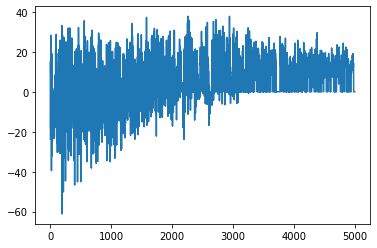

In [11]:
flatten = lambda l: [item for sublist in l for item in sublist]

l2 = flatten( records['rewards'])
l3 = [sum(ll) for ll in l2]

plt.figure()
plt.plot(l3)
# plt.plot(smooth(l2, 10))

In [12]:
# torch.save(records, 'results/records3')

# torch.save({'actor':seller_agent.actor.state_dict(),
#            'actor_target':seller_agent.actor_target.state_dict(),
#           'critic':seller_agent.critic.state_dict(),
#           'critic_target':seller_agent.critic_target.state_dict()}, 'results/models3')

In [13]:
# torch.save(seller_agent.memory, 'results/memory3')

# Some validation results 

In [39]:
mdict = torch.load('results/models3')
seller_agent.actor.load_state_dict(mdict['actor'])
seller_agent.actor_target.load_state_dict(mdict['actor_target'])

seller_agent.critic.load_state_dict(mdict['critic'])
seller_agent.critic_target.load_state_dict(mdict['critic_target'])

<All keys matched successfully>

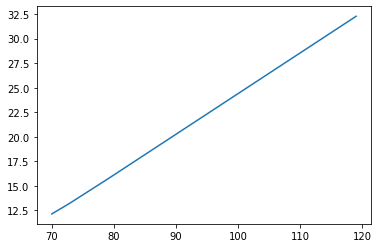

In [55]:
offers = []
with torch.no_grad():
    for i in range(70, 120):
#         self.state = np.array([self.last_demand, self.last_successful,
#                                self.game_first, self.round_first,
#                                self.reservation_price], dtype=np.float)
        state = np.array([0., 0., 1., 1., i], dtype=np.float)
        state = torch.tensor(state).float()
        
        seller_agent.actor.eval()
        o = seller_agent.actor(state)

        offers.append(o.item())
    
plt.figure()
plt.plot(range(70, 120), offers)

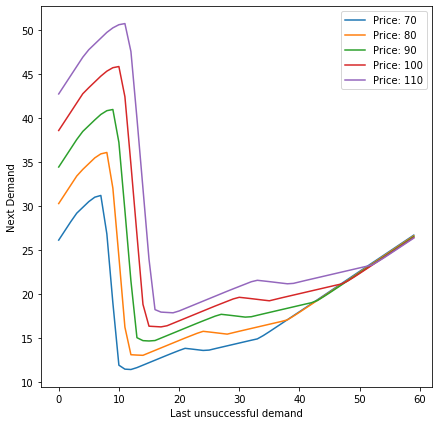

In [136]:
plt.figure(figsize=(7,7))
for price in [70, 80, 90, 100, 110]:
    offers = []
    with torch.no_grad():
        for i in range(0, 60):
    #         self.state = np.array([self.last_demand, self.last_successful,
    #                                self.game_first, self.round_first,
    #                                self.reservation_price], dtype=np.float)
            state = np.array([i, 0., 0., 0., price], dtype=np.float)
            state = torch.tensor(state).float()

            seller_agent.actor.eval()
            o = seller_agent.actor(state)
            offers.append(o.item())

    plt.plot(range(0, 60), offers, label='Price: ' + str(price))
    
plt.legend()
plt.ylabel('Next Demand')
plt.xlabel('Last unsuccessful demand');

plt.savefig('figs/rl_behaviour1.png', dpi=400)

In [96]:
epochs = 50

seller_agent.eval = True

data = []
offer_data = []

for e in range(epochs):
    seller_agent.reservation_price = generate_seller_prices_paper(1)[0]
    
    sellers = []
    for ii, p in enumerate(generate_seller_prices_paper(19)):
        sellers.append(RandomSeller('s'+str(ii), p))
    sellers.append(seller_agent)

    buyers = []
    for ii, p in enumerate(generate_buyer_prices_paper(20)):
        buyers.append(RandomBuyer('b'+str(ii), p))

    agents = sellers + buyers
    
    seller_agent.new_game()
    
    setting = {
        'self_last_offer': False,
        'same_side_last_offers': False,
        'other_side_last_offers': False,
        'completed_deals': False,
        'current_time': False,
        'max_time': False,
        'n_sellers': False,
        'n_buyers': False
    }

    ROUNDS_PER_GAME = 10
    
    market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_steps=10,
                                   matcher=RandomMatcher(reward_on_reference=True), setting=setting)
    init_observation = market_env.reset()

    round_avg = 0.
    offer_avg = 0.
    time_avg = 0.
    
    
#     round_prices = {a.agent_id:a.reservation_price for a in agents}
    game_offers = []

    for n_round in range(ROUNDS_PER_GAME):
        
        round_process_vs_rewards = {a.agent_id:[a.reservation_price, 0] for a in agents}
    
        
        init_observation = market_env.reset()
        observations = {k.agent_id:None for k in agents}
        done = {k.agent_id:False for k in agents}
        reward_hist = []
        rounds = 0
        terminate_round = False
        
        seller_agent.new_round()
        
        offers_list = []
        
        while not terminate_round:
            offers = {}

            offers = {a.agent_id : a.decide(observations[a.agent_id]) for a in agents if not done[a.agent_id]}

            observations, rewards, done, _ = market_env.step(offers)
            reward_hist.append(rewards)
            rounds += 1

            terminate_round = all(done.values()) or rounds >= 10
            
            for a in rewards:
                round_process_vs_rewards[a][1] += rewards[a]

            # create record of experience
            seller_agent.observe(rewards['learner'], terminate_round and n_round+1==ROUNDS_PER_GAME)
            
            if 'learner' in offers:
                offers_list.append(offers['learner'] - seller_agent.reservation_price)

                game_offers.append(offers['learner'] - seller_agent.reservation_price)

                records['demands'][-1][-1].append(offers['learner'] - seller_agent.reservation_price)
                records['rewards'][-1][-1].append(rewards['learner'])
            
                round_avg += rewards['learner']
            else:
                game_offers.append(np.nan)

            time_avg += 1
    
        offer_avg += sum(offers_list) / len(offers_list)

        data.append(round_process_vs_rewards)
        offer_data.append(game_offers)
        
#         if e >= warmup_epochs:
#             seller_agent.learn()
    
    print('Epoch: {}, Avg. earnings: {}, Avg. demand: {}, Avg. time: {}'.format(e, round_avg / 10., 
                                                                            offer_avg / 10.,
                                                                            time_avg / 10.))
    
    

Epoch: 0, Avg. earnings: 15.597995948791503, Avg. demand: 15.69843966960907, Avg. time: 10.0
Epoch: 1, Avg. earnings: 13.680740070343017, Avg. demand: 13.680740070343017, Avg. time: 10.0
Epoch: 2, Avg. earnings: 15.056887531280518, Avg. demand: 15.336217133204144, Avg. time: 10.0
Epoch: 3, Avg. earnings: 14.348589897155762, Avg. demand: 14.526032829284668, Avg. time: 10.0
Epoch: 4, Avg. earnings: 13.000730991363525, Avg. demand: 13.000730991363525, Avg. time: 10.0
Epoch: 5, Avg. earnings: 14.233322715759277, Avg. demand: 14.245607471466064, Avg. time: 10.0
Epoch: 6, Avg. earnings: 1.7090568542480469, Avg. demand: 17.23535566329956, Avg. time: 10.0
Epoch: 7, Avg. earnings: 0.0, Avg. demand: 19.080018653869633, Avg. time: 10.0
Epoch: 8, Avg. earnings: 4.809438323974609, Avg. demand: 16.16031317642757, Avg. time: 10.0
Epoch: 9, Avg. earnings: 4.979169845581055, Avg. demand: 16.728828620910644, Avg. time: 10.0
Epoch: 10, Avg. earnings: 0.0, Avg. demand: 19.33407045364379, Avg. time: 10.0
E

In [99]:
data

[{'s0': [88.34043644656626, 12.622166331200702],
  's1': [84.08744631211248, 2.3710476958794118],
  's2': [116.92304920074838, 0],
  's3': [91.91762989132067, 17.904665201810232],
  's4': [88.8235524228923, 8.876024284323165],
  's5': [100.08344773134878, 11.397581098136214],
  's6': [83.5225453644388, 8.046114201711546],
  's7': [93.28853725775657, 19.128639613492453],
  's8': [117.52895163554109, 0],
  's9': [75.04171950504328, 14.05141879471799],
  's10': [117.27197802242748, 0],
  's11': [95.43131196251447, 9.24061643591763],
  's12': [85.82917624134824, 19.198533006951394],
  's13': [102.23403988812183, 0],
  's14': [94.23718277455978, 0.5113734617551415],
  's15': [101.34718261600148, 1.9430722999804289],
  's16': [113.54314368770116, 0],
  's17': [102.62190581443953, 1.0112061196916784],
  's18': [113.9927176782428, 0],
  'learner': [91.27751936866407, 20.791452407836914],
  'b0': [131.37887936408447, 0],
  'b1': [133.91314726863254, 10.911260876311971],
  'b2': [139.88119702330

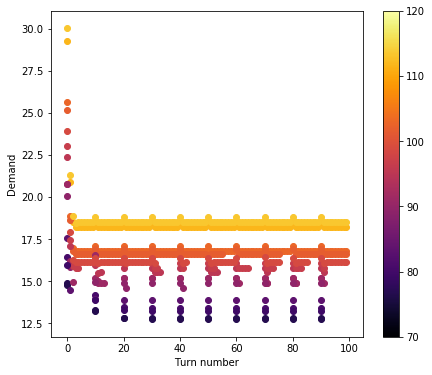

In [130]:
plt.figure(figsize=(7,6))

import matplotlib.colors as mcolors
import matplotlib.cm as cm

normalize = mcolors.Normalize(vmin=70, vmax=120)
colormap = cm.inferno

for i in range(15):
    ix = np.random.choice(len(offer_data))
#     ix = i
    
    
    plt.scatter(range(len(offer_data[ix])), offer_data[ix] , color=colormap(normalize(data[ix]['learner'][0])))
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(range(70,120))
plt.colorbar(scalarmappaple)
plt.xlabel('Turn number')
plt.ylabel('Demand')

plt.savefig('figs/rl_demands_per_round.png', dpi=400)

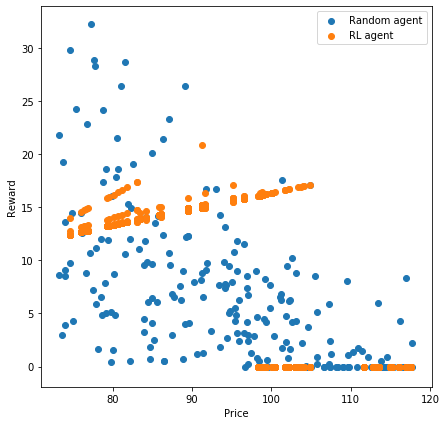

In [131]:
prices = [d['learner'][0] for d in data]
rewards = [d['learner'][1] for d in data]

scatter = [(d[k][0], d[k][1]) for d in data for k in d if k[0] != 'b']
scatter_random_sample = []

for i in range(250):
    scatter_random_sample.append(scatter[np.random.choice(len(scatter))])

prices_other = [s[0] for s in scatter_random_sample]
rewards_other = [s[1] for s in scatter_random_sample]



plt.figure(figsize=(7, 7))
plt.scatter(prices_other, rewards_other, label='Random agent')
plt.scatter(prices, rewards, label='RL agent')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Reward')


plt.savefig('figs/rl_reward_vs_price.png', dpi=400)

In [132]:
sum(rewards) / len(rewards)

8.738134746551514

In [133]:
sum(rewards_other) / len(rewards_other)

6.875501793912892